In [40]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from Unet.rle import masks_as_image, montage_rgb, montage
from skimage.segmentation import mark_boundaries
import seaborn as sns
from sklearn.utils import resample

In [20]:
BATCH_SIZE=32
IMG_SCALING = (3, 3)

In [2]:
train_image_dir = 'train_v2'
test_image_dir = 'test_v2'

In [32]:
df = pd.read_csv('train_ship_segmentations_v2.csv')
df.head(5)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [8]:
nempty = df.EncodedPixels.notna()
print(f"Dataset size: {len(df)}\nUnique number of images: {df.ImageId.nunique()}\nThere are {nempty.sum()} masks in {df[nempty].ImageId.nunique()} images\nThere are {(~nempty).sum()} empty images in {df.ImageId.nunique()} unique images")

Dataset size: 231723
Unique number of images: 192556
There are 81723 masks in 42556 images
There are 150000 empty images in 192556 unique images


In [34]:
df['ships'] = df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0) # Let's see if each image has ship or not
unique_img_ids = df.groupby('ImageId').agg({'ships': 'sum'}).reset_index() # Calculating amount of ships per image
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0) # To keep metric that tells if image has ships

unique_img_ids

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0
...,...,...,...
192551,fffedbb6b.jpg,0,0.0
192552,ffff2aa57.jpg,0,0.0
192553,ffff6e525.jpg,0,0.0
192554,ffffc50b4.jpg,0,0.0


<Axes: xlabel='ships', ylabel='count'>

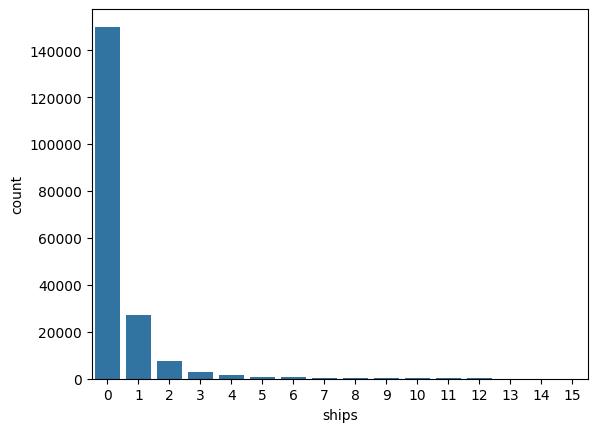

In [38]:
sns.countplot(unique_img_ids, x='ships') # Calculating number of images that have particular amount of ships

The dataset is highly unbalanced and it needs undersampling.

,ImageId,ships,has_ship,file_size_kb
73743,620efee61.jpg,0,0.0,107.130859
90233,77dc49d2d.jpg,0,0.0,310.681641
145365,c148e4e72.jpg,0,0.0,92.888672
14750,138966fce.jpg,0,0.0,190.936523
26704,238aca899.jpg,1,1.0,119.059570
82624,6daf83e5a.jpg,2,1.0,103.435547
110833,9353f70e5.jpg,0,0.0,99.063477


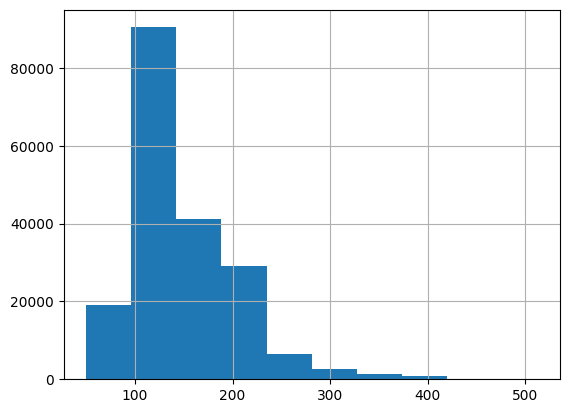

In [39]:
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb'] > 50] # keep only +50kb files
unique_img_ids['file_size_kb'].hist()
df.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(7)

In [ ]:
# Separate the dataset into images with ships and images without ships
images_with_ships = df[df['has_ship'] == 1]
images_without_ships = df[df['has_ship'] == 0]

# Undersample the images without ships to achieve a balanced dataset
undersampled_images_without_ships = resample(images_without_ships,
                                            replace=False,  # Set to True if you want to allow duplicates
                                            n_samples=len(images_with_ships),
                                            random_state=42)  # Set a random seed for reproducibility


12788 masks


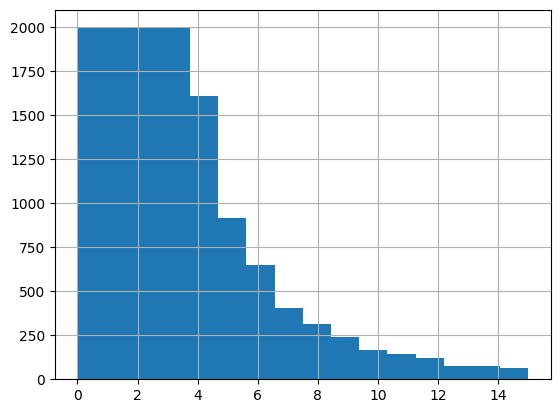

In [7]:
SAMPLES_PER_GROUP = 2000
balanced_train_df = unique_img_ids.groupby('ships').apply(lambda x: x.sample(SAMPLES_PER_GROUP) if len(x) > SAMPLES_PER_GROUP else x)
balanced_train_df['ships'].hist(bins=balanced_train_df['ships'].max()+1)
print(balanced_train_df.shape[0], 'masks')

In [8]:
train_ids, valid_ids = train_test_split(balanced_train_df, 
                 test_size = 0.2, 
                 stratify = balanced_train_df['ships'])
train_df = pd.merge(df, train_ids)
valid_df = pd.merge(df, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

35364 training masks
8838 validation masks


In [9]:
train_df.to_csv('train_df.csv', index=False)
valid_df.to_csv('valid_df.csv', index=False)

In [22]:
import tensorflow as tf
import numpy as np
from skimage.io import imread
from skimage.segmentation import find_boundaries
from skimage.draw import polygon

def make_image_gen_test(in_df, batch_size=BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    
    def generator():
        while True:
            np.random.shuffle(all_batches)
            for c_img_id, c_masks in all_batches:
                rgb_path = os.path.join(train_image_dir, c_img_id)
                c_img = imread(rgb_path)
                c_mask = np.expand_dims(masks_as_image(c_masks['EncodedPixels'].values), -1)
                
                if IMG_SCALING is not None:
                    c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                    c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
                
                yield c_img/255.0, c_mask

    dataset = tf.data.Dataset.from_generator(generator,
                                             output_signature=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.float32),
                                                               tf.TensorSpec(shape=(None, None, 1), dtype=tf.uint8)))

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset


In [27]:
train_ds = make_image_gen_test(train_df, 3)

In [32]:
x, y = next(train_ds.as_numpy_iterator())

x.shape, y.shape

((3, 256, 256, 3), (3, 256, 256, 1))

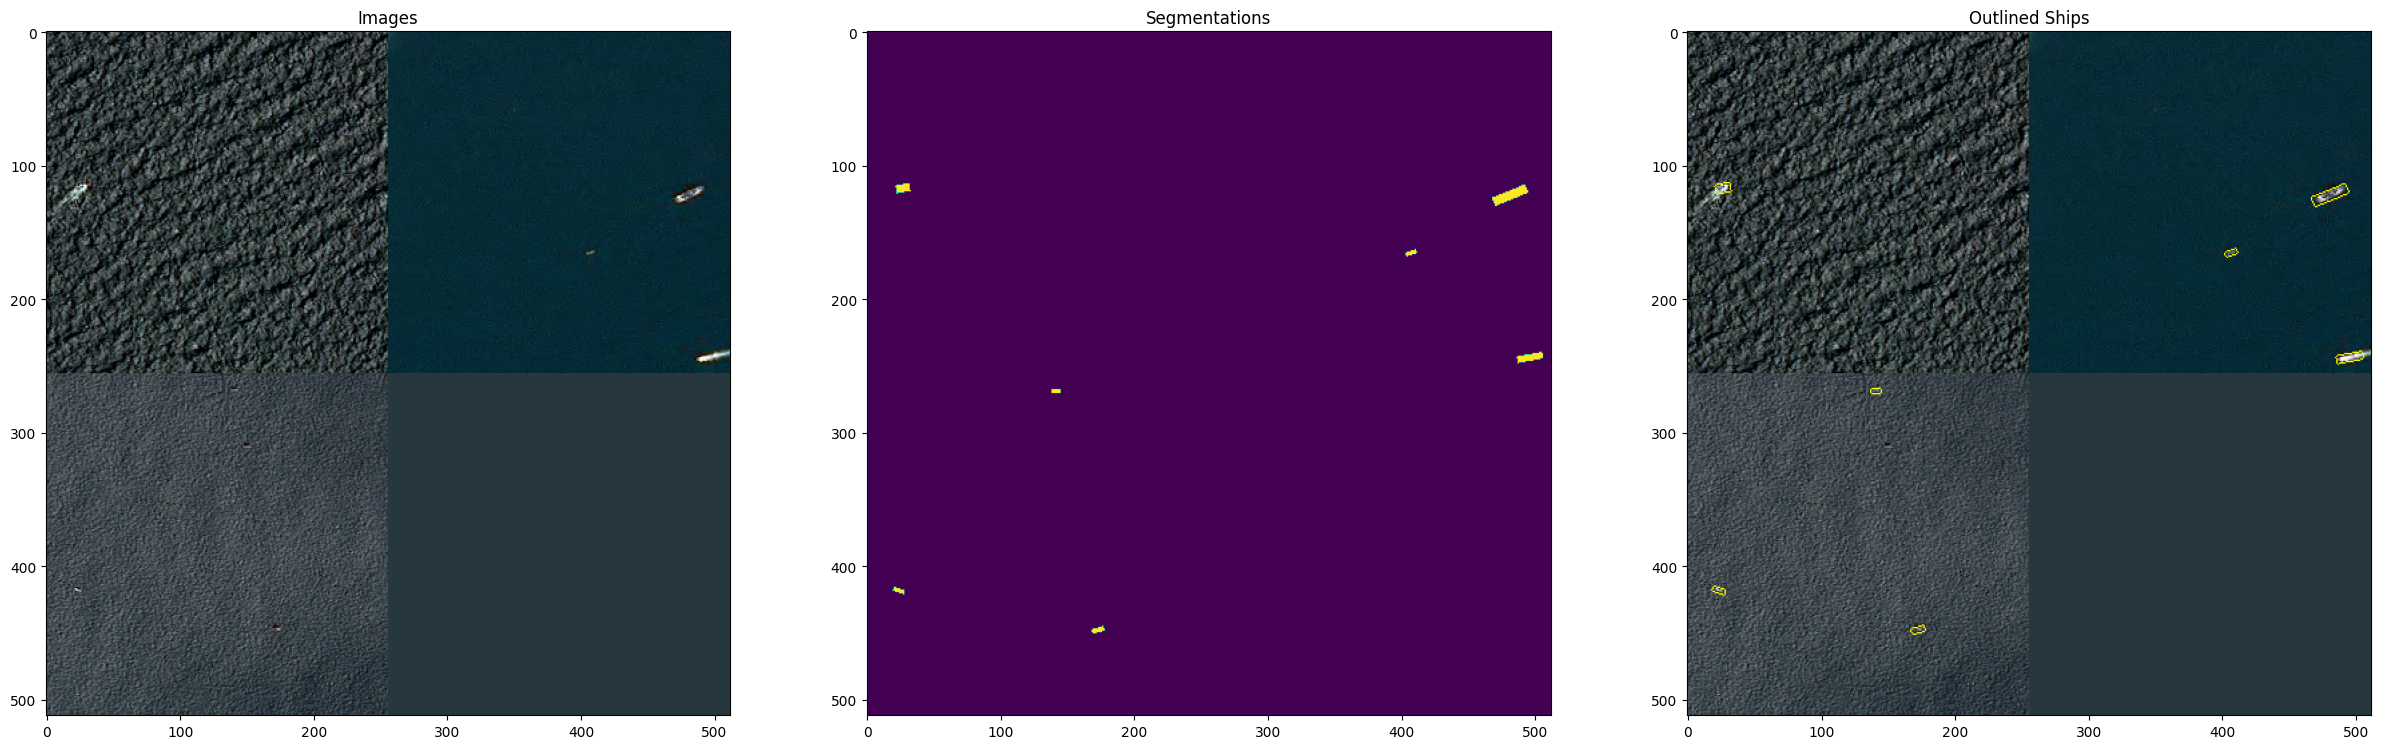

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(x)
batch_seg = montage(y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

In [12]:
valid_ds = make_image_gen_test(valid_df, VALID_IMG_COUNT).as_numpy_iterator()
valid_x, valid_y = next(valid_ds)
print(valid_x.shape, valid_y.shape)

(900, 256, 256, 3) (900, 256, 256, 1)


In [13]:
input_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.25, seed=42),  # Rotation range is -45 to 45 degrees
    tf.keras.layers.RandomWidth(factor=0.1, seed=42),  # Width shift range is -10% to 10%
    tf.keras.layers.RandomHeight(factor=0.1, seed=42),  # Height shift range is -10% to 10%
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.25), width_factor=(-0.1, 0.25), seed=42),  # Zoom range is 0.9 to 1.25
    tf.keras.layers.RandomFlip("horizontal", seed=42),  # Horizontal flip
    tf.keras.layers.RandomFlip("vertical", seed=42),
    tf.keras.layers.Resizing(256, 256)
])
output_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.25, seed=42),  # Rotation range is -45 to 45 degrees
    tf.keras.layers.RandomWidth(factor=0.1, seed=42),  # Width shift range is -10% to 10%
    tf.keras.layers.RandomHeight(factor=0.1, seed=42),  # Height shift range is -10% to 10%
    tf.keras.layers.RandomZoom(height_factor=(-0.1, 0.25), width_factor=(-0.1, 0.25), seed=42),  # Zoom range is 0.9 to 1.25
    tf.keras.layers.RandomFlip("horizontal", seed=42),  # Horizontal flip
    tf.keras.layers.RandomFlip("vertical", seed=42),
    tf.keras.layers.Resizing(256, 256)
])

In [145]:
output_augmentation(y).shape

TensorShape([2, 256, 256, 1])

In [14]:
def augmentation(input_img, output_img):
    return input_augmentation(input_img), output_augmentation(output_img)

augmented_ds = train_ds.map(augmentation)

<_MapDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None))>

In [44]:
x.shape, input_augmentation(x).shape

((2, 256, 256, 3), TensorShape([2, 268, 268, 3]))

Text(0.5, 1.0, 'Segmentations')

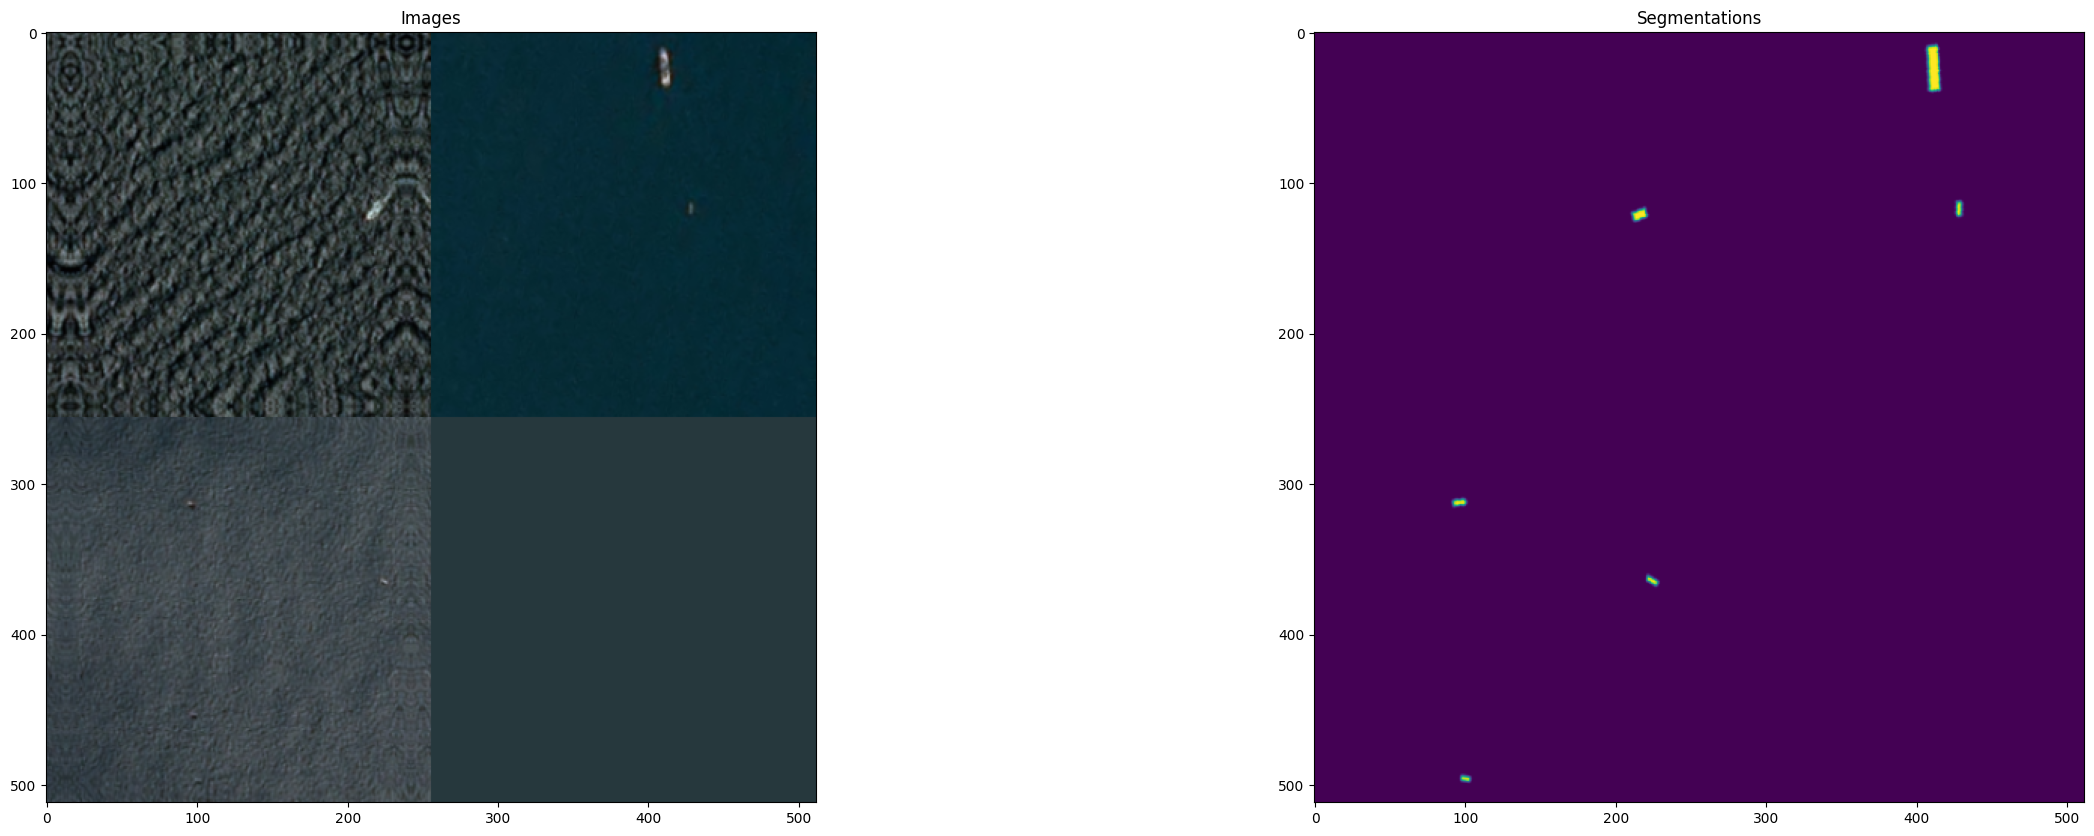

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (30, 10))
batch_rgb = montage_rgb(input_augmentation(x))
batch_seg = montage(output_augmentation(y)[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Middle
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.concatenate([conv2, up1], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.concatenate([conv1, up2], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [16]:
# Create the model
model = unet_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2), dice_coefficient, dice_coff])

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1)

checkpoint_path = "model_checkpoint.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [27]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=[dice_coff])

In [18]:
history = model.fit(augmented_ds, validation_data=valid_ds, epochs=100, verbose=1, callbacks=[early_stopping, checkpoint_callback], 
                    steps_per_epoch=min(MAX_TRAIN_STEPS, len(train_df)//BATCH_SIZE))

Epoch 1/100
  2/300 [..............................] - ETA: 4:01:29 - loss: 0.6438 - accuracy: 0.5158 - mean_io_u: 0.4991 - dice_coefficient: 0.0109 - dice_coff: 0.0109

KeyboardInterrupt: 

In [44]:
import tensorflow as tf
from Unet.metrics import dice_coff
loaded_model = tf.keras.models.load_model('Unet/model.h5', custom_objects={"dice_coff": dice_coff})
loaded_model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_171 (Conv2D)         (None, 256, 256, 8)          224       ['input_10[0][0]']            
                                                                                                  
 dropout_81 (Dropout)        (None, 256, 256, 8)          0         ['conv2d_171[0][0]']          
                                                                                                  
 conv2d_172 (Conv2D)         (None, 256, 256, 8)          584       ['dropout_81[0][0]']          
                                                                                               

In [ ]:
predicted = model.predict(valid_x)